In [1]:
import ee
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

ee.Authenticate()

ee.Initialize(project='ee-your-project')

In [3]:
# Load infoTable.csv as point features
infoTable = pd.read_csv(
    f"{(os.path.abspath("")).strip('python')}/example-data/formatted-tables/infoTable.csv", 
    sep=',', 
    encoding='utf-8')

# 'st_lat' and 'st_long' are still on DDº MM' SS" format, we need to convert them to decimal degrees
def dms_to_dd(dms):
# Needs to split º, ' and " to convert to decimal degrees
    dms = dms.replace('°', ' ').replace('\'', ' ').replace('\"', ' ')
    dms = dms.split()
    degrees = float(dms[0])
    minutes = float(dms[1]) / 60
    seconds = float(dms[2]) / 3600
    return degrees + minutes + seconds

infoTable['st_lat'] = (infoTable['st_lat'].apply(dms_to_dd))*-1
infoTable['st_long'] = (infoTable['st_long'].apply(dms_to_dd))*-1

# Convert to GeoDataFrame
infoTable_gdf = gpd.GeoDataFrame(
    infoTable, geometry=gpd.points_from_xy(infoTable['st_long'], infoTable['st_lat'], crs='EPSG:4326'))

<>:2: SyntaxWarning: invalid escape sequence '\e'
<>:2: SyntaxWarning: invalid escape sequence '\e'
C:\Users\mateu\AppData\Local\Temp\ipykernel_7600\2321862206.py:2: SyntaxWarning: invalid escape sequence '\e'
  arapressao = gpd.read_file(f"{(os.path.abspath("")).strip('python')}\example-data/arapressao-limits/arapressao.shp")
C:\Users\mateu\AppData\Local\Temp\ipykernel_7600\2321862206.py:5: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  infoTable_gdf = infoTable_gdf[infoTable_gdf.geometry.within(arapressao.unary_union)]


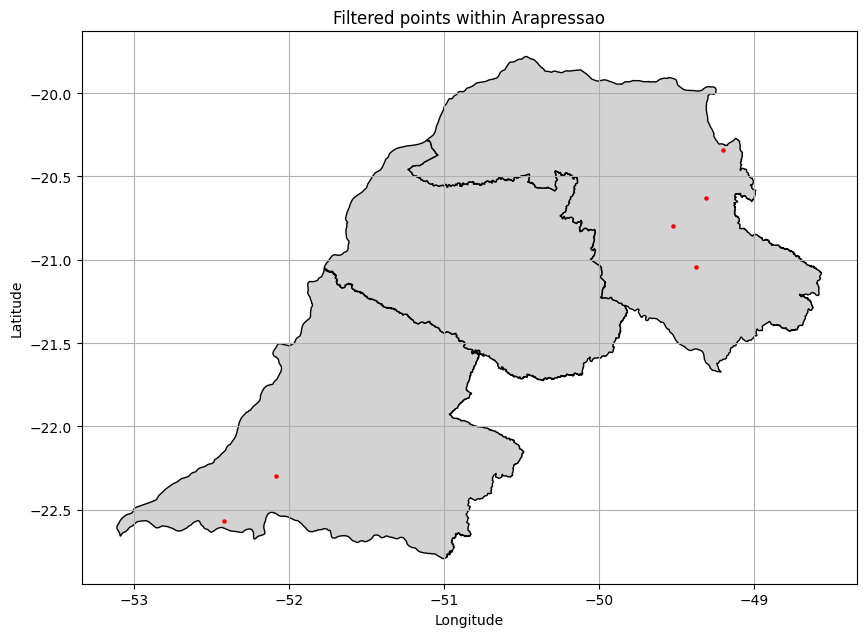

In [4]:
# Load arapressao shapefile as GeoDataFrame
arapressao = gpd.read_file(f"{(os.path.abspath("")).strip('python')}\example-data/arapressao-limits/arapressao.shp")

# Clip infoTable_gdf to arapressao
infoTable_gdf = infoTable_gdf[infoTable_gdf.geometry.within(arapressao.unary_union)]

# From 'st_start_dt' and 'st_end_dt' (YYYY-MM-DD), create two columns with the start and end years only
infoTable_gdf['start_year'] = pd.to_datetime(infoTable_gdf['st_start_dt']).dt.year
infoTable_gdf['end_year'] = pd.to_datetime(infoTable_gdf['st_end_dt']).dt.year

# 'error_perc' must be < 10
infoTable_gdf = infoTable_gdf[infoTable_gdf['error_perc'] < 10]

# Filter if start_year > 1985 and end_year < 2023
infoTable_gdf = infoTable_gdf[(infoTable_gdf['start_year'] <= 1985) & (infoTable_gdf['end_year'] >= 2023)]

# Visualize the points
fig, ax = plt.subplots(figsize=(10, 10))
arapressao.plot(ax=ax, color='lightgrey', edgecolor='black')
infoTable_gdf.plot(ax=ax, color='red', markersize=5)
plt.title('Filtered points within Arapressao')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.show()

In [ ]:
# Initialize Earth Engine
import ee
import geemap
ee.Initialize()

# Convert to FeatureCollection and buffer while preserving attributes
infoTable_fc = geemap.geopandas_to_ee(infoTable_gdf).map(lambda feature: feature.buffer(12500))

# Define parameters
attribute = "st_code"  # The identifier attribute
classIds = list(range(71))  # Classes 0-70
scale = 30  # Resolution in meters
years = list(range(1985, 2024))  # 2024 excluded

# Load MapBiomas collection
mapbiomas = ee.Image('projects/mapbiomas-public/assets/brazil/lulc/collection9/mapbiomas_collection90_integration_v1')

# Pixel area in km2
pixelArea = ee.Image.pixelArea().divide(1000000)

def calculate_area(image, territory_fc, year):
    """Corrected area calculation function"""
    # Select the year band
    classified = image.select(f'classification_{year}')
    
    # Calculate area for each feature
    def calc_feature_area(feature):
        # Create image with area and classification bands
        img = pixelArea.addBands(classified)
        
        # Calculate area per class - critical band ordering
        reduction = img.reduceRegion(
            reducer=ee.Reducer.sum().group(
                groupField=1,  # Classification band is now band 1
                groupName='class'
            ),
            geometry=feature.geometry(),
            scale=scale,
            maxPixels=1e12
        )
        
        # Process results
        groups = ee.List(reduction.get('groups'))
        
        def process_group(group):
            group = ee.Dictionary(group)
            return ee.Feature(None, {
                attribute: feature.get(attribute),
                'class': ee.Number(group.get('class')).format(),
                'area': ee.Number(group.get('sum')).format(),
                'year': str(year)
            })
        
        return ee.FeatureCollection(groups.map(process_group))
    
    return territory_fc.map(calc_feature_area).flatten()

# Process years
results = []
for year in years:
    results.append(calculate_area(mapbiomas, infoTable_fc, year))

# Combine results
all_results = ee.FeatureCollection(results).flatten()

# Export to pandas
landUseDf = geemap.ee_to_df(all_results)

# Clean up class numbers (convert from scientific notation)
landUseDf['class'] = landUseDf['class'].astype(float).round().astype(int)

# Convert area to km2
landUseDf['area'] = landUseDf['area'].astype(float).round(2)

In [ ]:
# Visualize the results
display(landUseDf.tail(10))

In [ ]:
# Calculate mean area per class per year across all stations
landUseDf_mean = landUseDf.groupby(['class', 'year'])['area'].mean().reset_index()

# Convert year to numeric
landUseDf_mean['year'] = pd.to_numeric(landUseDf_mean['year'])

# Create a mapping dictionary
classDict = {
    1: "Forest", 3: "Forest Formation", 4: "Savanna Formation",       
    5: "Mangrove", 6: "Floodable Forest (beta)", 9: "Forest Plantation",       
    10: "Non Forest Natural Formation", 11: "Wetland", 12: "Grassland",              
    13: "Other non Forest Formations", 14: "Farming", 15: "Pasture",                
    18: "Agriculture", 19: "Temporary Crop", 20: "Sugar cane",             
    21: "Mosaic of Uses", 22: "Non vegetated area", 23: "Beach, Dune and Sand Spot",
    24: "Urban Area", 25: "Other non Vegetated Areas", 26: "Water",                 
    27: "Not Observed", 29: "Rocky Outcrop", 30: "Mining",                 
    31: "Aquaculture", 32: "Hypersaline Tidal Flat", 33: "River, Lake and Ocean",  
    35: "Palm Oil (beta)", 36: "Perennial Crop", 39: "Soybean",                
    40: "Rice", 41: "Other Temporary Crops", 46: "Coffee",                 
    47: "Citrus", 48: "Other Perennial Crops", 49: "Wooded Sandbank Vegetation",
    50: "Herbaceous Sandbank Vegetation", 62: "Cotton (beta)"
}

# Map class IDs to names
landUseDf_mean['class'] = landUseDf_mean['class'].map(classDict)
# Convert class to categorical
landUseDf_mean['class'] = pd.Categorical(landUseDf_mean['class'], categories=sorted(classDict.values()), ordered=True)
# Sort by class and year
landUseDf_mean = landUseDf_mean.sort_values(['class', 'year'])

# Get unique classes after mapping
unique_classes = landUseDf_mean['class'].unique()
n_classes = len(unique_classes)
n_cols = 4
n_rows = int(np.ceil(n_classes / n_cols))

# Create figure
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 5*n_rows))
fig.suptitle('Mean land use across stations (12.5 km buffer)', y=1.02, fontsize=14)
axes = axes.flatten()

for i, class_name in enumerate(unique_classes):
    class_data = landUseDf_mean[landUseDf_mean['class'] == class_name].sort_values('year')
    
    # Plot line with mean values
    axes[i].plot(class_data['year'], class_data['area'], 
                'o-', linewidth=2, markersize=5, color='steelblue')
    
    axes[i].set_title(class_name, pad=10)  # Use the class name directly
    axes[i].set_ylabel('Mean area (km²/year)')
    axes[i].set_xlabel('Year')
    axes[i].grid(True, alpha=0.3)
    
    # Set consistent x-axis limits
    axes[i].set_xlim([1985, 2023])
    axes[i].set_xticks(range(1985, 2024, 5))  # Show ticks every 5 years

# Hide empty subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Calculate mean area per class per year across all stations
landUseDf_mean = landUseDf.groupby(['class', 'year'])['area'].mean().reset_index()

# Convert year to numeric
landUseDf_mean['year'] = pd.to_numeric(landUseDf_mean['year'])

# Map class IDs to names
landUseDf_mean['class'] = landUseDf_mean['class'].map(classDict)

# Pivot the data to have years as index and classes as columns
pivot_df = landUseDf_mean.pivot(index='year', columns='class', values='area')

# Create a stacked bar chart
plt.figure(figsize=(15, 8))

# Get a list of colors for each class
colors = plt.cm.tab20(np.linspace(0, 1, len(pivot_df.columns)))

# Plot stacked bars
pivot_df.plot(kind='bar', stacked=True, color=colors, ax=plt.gca(), width=0.8)

plt.title('Land use distribution by year (all classes - 12.5 km buffer)\n' \
'Keep in mind that due to the values being means across stations, the sum may not be equal across all years!', fontsize=14, pad=20)
plt.ylabel('Mean area (km²/year)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Move legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

# Now with minor classes
# Pasture, Sugar cane and Mosaic of Uses are major classes, so we will remove them from the plot
pivot_df = pivot_df.drop(columns=['Pasture', 'Sugar cane', 'Mosaic of Uses'], errors='ignore')

# Plot again
plt.figure(figsize=(15, 8))

# Get a list of colors for each class
colors = plt.cm.tab20(np.linspace(0, 1, len(pivot_df.columns)))

# Plot stacked bars
pivot_df.plot(kind='bar', stacked=True, color=colors, ax=plt.gca(), width=0.8)
plt.title('Land use distribution by year (minor classes - 12.5 km buffer)', fontsize=14, pad=20)
plt.ylabel('Mean area (km²/year)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Move legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()